# 강화학습 기초 - **DQN** 구현


---


1. 강화학습의 이해와 **Q-러닝/DQN**

2. 기본 개념부터 **Keras/TensorFlow** 구현

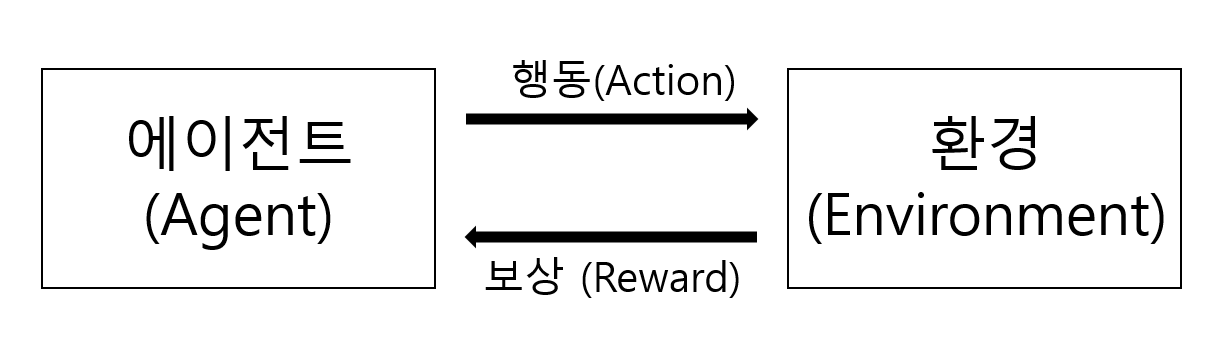

In [1]:
# 강화학습(RL)환경을 불러올 때 사용하는 코드 -> 강화학습 실험을 위한 가상환경 모음집
# gymnasium는 gym의 후속버전
import gymnasium as gym  # OpenAI에서 만든 라이브러리, 다양한 시뮬레이션 환경 제공하여 AI 에이전트가 학습할 수 있도록 도와주는 도구

import numpy as np  
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras import layers  
import random  
import matplotlib.pyplot as plt  
import time

### 예시 환경들:

- 환경 이름	설명:
  - CartPole-v1	막대기를 수직으로 세우기
  - MountainCar-v0	언덕 넘기
  - Acrobot-v1	로봇 팔 회전시키기
  - LunarLander-v2	달 착륙선 제어하기
  - Atari 게임들	Breakout, Pong 같은 고전 게임

In [ ]:
# gymnasium 예시

env = gym.make('CartPole-v1', render_mode='human')   # 환경 생성
obs, _ = env.reset()        # 환경 초기화

for _ in range(1000):
    env.render()        # 환경 시각화
    action = env.action_space.sample()      # 임의의 행동 선택
    obs, reward, terminated, truncated, info = env.step(action)     # 행동 수행

    if terminated or truncated:
        obs, _ = env.reset()        # 에피소드 끝났으면 초기화

env.close()


In [ ]:
# Colab 코드

import gymnasium as gym
import time

# 환경 생성: render_mode='human'은 Colab에서는 동작하지 않음!
# 대신 'rgb_array'로 이미지 프레임을 얻어서 직접 출력해야 해
env = gym.make('CartPole-v1', render_mode='rgb_array')

obs, _ = env.reset()

for _ in range(1000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    # 시각화: 현재 프레임을 가져와서 Colab에 표시
    frame = env.render()  # numpy array (H x W x 3)

    # Colab에서 이미지 표시
    from IPython.display import display, clear_output
    from PIL import Image
    clear_output(wait=True)
    display(Image.fromarray(frame))
    time.sleep(0.02)

    if terminated or truncated:
        obs, _ = env.reset()

env.close()

## Keras와 Tensorflow로 DQN 구현

1. OpenAI Gym 라이브러리를 사용하여 강화학습 실험에 자주 쓰이는 "CartPole-v1" 환경을 생성하세요. CartPole 환경은 막대기(폴)와 카트(카트)를 사용하여 균형 잡기 문제를 다루는 전형적인 강화학습 예제입니다. 환경을 생성할 때, 환경의 상태가 시각적으로 렌더링되도록 설정하세요.

In [ ]:
env = gym.make("CartPole-v1", render_mode='human')
state_size = env.observation_space.shape[0]  # 상태 공간 크기 (4차원)
action_size = env.action_space.n  # 행동 개수 (2개: 왼쪽/오른쪽) 에이전트가 취할 수 있는 행동들의 집합
print("State size:", state_size)
print("Action size:", action_size)

State size: 4
Action size: 2


- env.observation_space:

  - 환경의 관측(상태) 공간을 나타내며, 이 경우 연속적인 값들의 배열로 표현됩니다.

  - CartPole 환경에서는 관측 값이 4개의 연속적인 값(예: 카트의 위치, 카트의 속도, 막대기의 각도, 막대기의 각속도)으로 구성됩니다.

- env.observation_space.shape[0]:

  - 관측 공간의 shape(모양)은 (4,)와 같이 4개의 값으로 이루어져 있다는 정보를 담고 있습니다.

  - [0] 인덱스를 통해 첫 번째(그리고 유일한) 차원의 크기를 추출하여 state_size에 저장합니다.

  - 따라서, state_size는 4가 됩니다.

2. Keras를 활용하여 강화학습 (특히 DQN)에서 사용할 신경망 모델을 구축하세요. 모델의 입력 크기와 에이전트가 취할 수 있는 행동의 개수를 파라미터로 입력 받을 수 있게 작성하세요.  


- keras.Sequential: 여러 층을 순차적으로 쌓아 올리는 방식의 모델입니다.

- 첫 번째 Dense 층:

  - layers.Dense(24, activation='relu', input_shape=(state_size,))

  - 뉴런 수: 24개

  - 활성화 함수: ReLU (Rectified Linear Unit)

    - 학습 과정에서 비선형성을 추가해줌으로써 복잡한 함수도 근사할 수 있게 합니다.

  - input_shape=(state_size,):

    -모델이 입력으로 받을 데이터의 형태를 지정합니다. 여기서는 상태 벡터의 크기만큼의 입력을 받습니다.

- 두 번째 Dense 층:

  - layers.Dense(24, activation='relu')

  - 또 다른 은닉층으로, 24개의 뉴런과 ReLU 활성화 함수를 사용합니다.

  - 첫 번째 층으로부터 나온 출력을 받아 추가적인 비선형 변환을 수행합니다.

- 세 번째 Dense 층 (출력층):

  - layers.Dense(action_size, activation='linear')

  - 뉴런 수: action_size (즉, 가능한 행동의 수)

  - 활성화 함수: linear

    - 출력층에서 linear 활성화 함수를 사용하면, 각 행동에 대한 Q-값을 그대로 출력합니다.

    - Q-값은 특정 상태에서 특정 행동을 취했을 때 기대되는 누적 보상입니다.



In [ ]:
def build_model(state_size, action_size):
    model = keras.Sequential([
        layers.Dense(24, activation='relu', input_shape=(state_size,)),  
        layers.Dense(24, activation='relu'),  
        layers.Dense(action_size, activation='linear')  # 각 행동의 Q-값 출력
    ])
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001)) # 실제 Q-값과 신경망이 예측한 Q-값 사이의 평균 제곱 오차를 손실 함수로 사용합니다.
    # 강화학습에서는 Q-러닝 업데이트에서 발생하는 오차를 줄이기 위해 MSE를 흔히 사용합니다.
    return model    # 컴파일한 모델 반환

# 모델 생성
model = build_model(state_size, action_size)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

3. 강화학습에서 경험 재사용(Experience Replay)을 구현하기 위한 버퍼(메모리) 클래스를 정의하겠습니다.  
ReplayBuffer 클래스를 정의하고 ```max_size=2000```를 매개변수로 설정, ```buffer=[]```, ```max_size=max_size```를 초기화 메서드에 추가하세요.

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=2000): # (기본값 2000): 버퍼에 저장할 수 있는 최대 경험의 개수를 제한합니다.
        self.buffer = []            # 빈 리스트로 초기화되며, 경험들을 저장하는 곳입니다.
        self.max_size = max_size    # 입력받은 최대 크기를 저장하는 변수입니다.

    # 경험 추가 메서드
    def add(self, experience): # 환경과의 상호작용을 통해 얻은 경험 데이터입니다. 보통 (state, action, reward, next_state, done)와 같은 튜플 형태를 가집니다.
        self.buffer.append(experience) # 입력받은 경험을 버퍼(리스트)에 추가합니다.
        if len(self.buffer) > self.max_size: # 크기 제한 체크
            self.buffer.pop(0) # 버퍼의 가장 오래된 경험(리스트의 첫 번째 요소)을 제거합니다.
            # 이 방식으로 버퍼는 항상 최신의 경험을 유지하면서 최대 크기를 넘지 않도록 관리합니다.

    # 경험 샘플링 메서드
    def sample(self, batch_size): # 샘플링할 경험의 개수를 지정합니다.
        return random.sample(self.buffer, batch_size) # 파이썬의 random 모듈을 사용하여 버퍼 내의 경험들 중 무작위로 batch_size 만큼의 항목을 선택하여 반환합니다.
        # 무작위 추출은 경험들 간의 상관관계를 줄이고, 안정적인 학습을 돕습니다.

# 경험 저장 버퍼 생성
memory = ReplayBuffer(max_size=2000)


4. 강화학습 에이전트가 행동을 선택할 때 사용하는 ε-탐욕(epsilon-greedy) 전략을 구현하겠습니다.

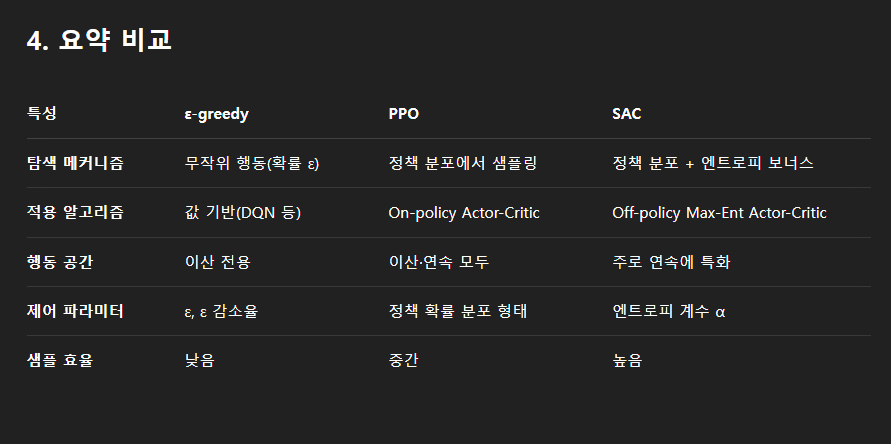

ε-greedy는 주로 값 기반(Value-based) 알고리즘(DQN 등)에서 쓰이는 간단한 탐색 전략이고, PPO나 SAC 같은 정책 기반(Policy-based)·Actor-Critic 계열 알고리즘의 탐색 메커니즘과는 여러 측면에서 다릅니다.

1. ε-greedy 탐색 방식
- 동작 원리

  - 확률 ε로 “무작위 행동(Explore)”을 선택하고, 나머지 1−ε 확률로 “현재 Q값이 최대인 행동(Exploit)”을 선택

  - DQN 같은 Q-러닝 계열에서 Q-값 예측치에 기반해 행동을 고를 때 사용

- 특징

  - 간단: 구현이 매우 쉽고 직관적

  - 탐색 균형: ε 스케줄(감소율)을 통해 탐색·활용 비율을 조절

  - 제한:

    - 이산 행동 공간에만 자연스럽게 적용

    - ε가 낮으면 탐색이 부족해지고, 높으면 지나친 무작위성으로 수렴이 느려짐

    - 환경 구조를 고려하지 못하고 완전 무작위성에 의존 → 고차원·연속 공간에서는 효율이 떨어짐

In [ ]:
# state: 현재 환경의 상태를 나타내는 배열(벡터)입니다. 예를 들어, CartPole 환경에서는 카트의 위치, 속도, 막대의 각도, 각속도 등을 포함합니다.
# epsilon: 탐색 확률을 나타내며, 0과 1 사이의 값을 가집니다. 이 값이 높을수록 에이전트가 무작위 탐색(Explore)을 할 확률이 커집니다.

def select_action(state, epsilon):
    #  탐색(Explore) vs. 활용(Exploit) 결정
    if np.random.rand() < epsilon:  # 작으면 탐색 (Explore)
        return np.random.choice(action_size)    # 이 경우, 아직 학습되지 않은 행동들을 시도해 봄으로써 새로운 정보를 얻습니다.
    else:  # 활용 (Exploit) 즉, 현재까지 학습한 지식을 기반으로 가장 높은 보상을 줄 것으로 기대되는 행동을 선택합니다.
        q_values = model.predict(state[np.newaxis, :])  # 이 코드에서는 학습된 신경망 모델(model)을 사용하여, 현재 상태에 대한 각 행동의 Q-값(보상 예상치)를 예측합니다.
        return np.argmax(q_values[0]) # 예측된 Q-값 중 가장 큰 값을 갖는 행동의 인덱스를 선택합니다.

5. DQN(Deep Q-Network) 알고리즘에서 신경망 모델을 학습시키기 위한 한 번의 훈련 단계를 구현하겠습니다. 경험 재사용(Experience Replay) 버퍼에 저장된 샘플들을 이용해 모델의 예측값(Q-값)을 업데이트합니다.

- 함수 시그니처:

  - model: 현재 학습 중인 Q-네트워크로, 상태를 입력 받아 각 행동의 Q-값을 예측합니다.

  - target_model: 일정 주기마다 model의 파라미터를 복사한 안정적인 Q-네트워크입니다. 여기서는 다음 상태의 Q-값을 계산하는 데 사용됩니다.

  - memory: 에이전트가 환경과 상호작용하며 획득한 경험을 저장하는 ReplayBuffer 객체입니다.

  - batch_size: 학습 시 샘플링할 경험의 개수.

  - gamma (할인 인자): 미래 보상의 현재 가치를 계산할 때 사용하는 할인율(여기서는 0.95).

- 샘플 수 체크:

  - if len(memory.buffer) < batch_size:
    학습에 사용할 샘플의 수가 미리 정해진 batch_size보다 작으면, 학습을 진행하지 않고 함수를 종료합니다.

  - 이를 통해 충분한 경험이 쌓이기 전에는 모델 업데이트가 일어나지 않도록 합니다.

In [ ]:
# 함수 정의 및 초기 샘플 체크

def train_model(model, target_model, memory, batch_size, gamma=0.95):
    if len(memory.buffer) < batch_size:
        return  # 샘플 부족

    # 경험 샘플링 및 데이터 준비
    batch = memory.sample(batch_size) # ReplayBuffer에서 무작위로 batch_size 만큼의 경험 샘플을 추출합니다.
    states, actions, rewards, next_states, dones = zip(*batch) # 언패킹 (Unpacking): 각 경험은 보통 (state, action, reward, next_state, done) 형태의 튜플로 구성됩니다.

    # states와 next_states는 모델 입력으로 사용하기 위해 NumPy 배열로 변환합니다.
    # 이 배열들은 모델의 predict 함수에 한 번에 여러 상태를 전달하기 위한 형태로 준비됩니다.
    states = np.array(states)
    next_states = np.array(next_states)
    
    # Q-값 예측
    q_values = model.predict(states) # 현재 신경망(model)으로 각 상태에서 가능한 각 행동의 Q-값을 예측합니다.
    next_q_values = target_model.predict(next_states) # 안정적인 타겟 네트워크(target_model)를 사용하여, 다음 상태에 대한 Q-값을 예측합니다.

    # 배치 내 각 샘플에 대해 반복하면서, Q-러닝 업데이트의 타겟 값을 계산합니다.
    for i in range(batch_size):
        target = rewards[i] # 즉시 보상: 현재 단계에서 받은 보상(reward)을 초기 타겟 값으로 설정합니다.
        if not dones[i]:  # 미래 보상 고려: 종료되지 않은 경우
            target += gamma * np.max(next_q_values[i]) # 다음 상태에서 가능한 행동들 중 가장 큰 Q-값에 할인율 gamma를 곱해 누적 보상에 추가
            # 벨만 방정식(Bellman Equation)의 핵심 아이디어를 반영

        q_values[i][actions[i]] = target # Q-값 업데이트: 예측된 Q-값 배열 중, 실제 선택된 행동(actions[i])에 해당하는 위치의 값을 우리가 계산한 타겟 값으로 대체

    # 모델 학습
    model.fit(states, q_values, epochs=1, verbose=0) # 현재 상태(states)를 입력으로 하고 업데이트된 Q-값(q_values)을 타겟 값으로 삼아 신경망을 학습


6. DQN(Deep Q-Network)을 활용하여 에이전트를 CartPole 환경에서 학습시키는 전체적인 학습 루프를 구성 및 실행하는 코드를 작성해주세요.

In [ ]:

num_episodes = 500  
batch_size = 32  
gamma = 0.95  
epsilon = 1.0 
epsilon_decay = 0.995 
epsilon_min = 0.01 
target_update_freq = 10

target_model = build_model(state_size, action_size) 
target_model.set_weights(model.get_weights()) 

for episode in range(num_episodes):
    state = env.reset()[0] 
    total_reward = 0

    for t in range(200):  
        action = select_action(state, epsilon) 
        next_state, reward, done, _, _ = env.step(action)
        
        memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if done:
            break

    train_model(model, target_model, memory, batch_size, gamma)

    if episode % target_update_freq == 0:  
        target_model.set_weights(model.get_weights())  

    epsilon = max(epsilon_min, epsilon * epsilon_decay) 

    print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")


In [ ]:
# 하이퍼파라미터 설정

num_episodes = 500  # 전체 학습 에피소드 수로, 여기서는 500 에피소드를 실행합니다.
batch_size = 32  # 한 번의 학습(업데이트)마다 ReplayBuffer에서 샘플링할 경험의 개수입니다(32개).
gamma = 0.95  # (할인 인자): 미래 보상의 현재 가치를 계산할 때 사용하는 값으로, 0.95로 설정되어 있습니다. 즉, 미래 보상에 대해 95%의 가중치를 부여합니다.
epsilon = 1.0  # 초기 ε 값으로, 현재는 1.0입니다. 이는 에이전트가 초반에 전적으로 탐색(random action 선택)을 하게 함을 의미합니다.
epsilon_decay = 0.995  # 각 에피소드가 끝날 때마다 ε 값을 얼마나 줄일지 정하는 값입니다. 여기서는 0.995배씩 감소시켜 점진적으로 exploitation(최적 행동 선택)을 늘립니다.
epsilon_min = 0.01  # ε의 하한값으로, 0.01 이상으로는 감소하지 않아 탐색 확률이 완전히 0이 되지 않도록 합니다.
target_update_freq = 10  # 일정 주기마다 타겟 네트워크를 업데이트(현재 모델의 가중치 복사)하기 위한 에피소드 간격입니다. 여기서는 10 에피소드마다 업데이트합니다.



target_model = build_model(state_size, action_size) # 앞서 만든 DQN용 모델 구조를 기반으로 타겟 네트워크를 생성합니다.
target_model.set_weights(model.get_weights())  # 초기 타겟 네트워크 설정 - 타겟 네트워크는 모델 업데이트 시마다 조금씩 지연되어 학습의 안정성을 도모

# 총 500회 실행
for episode in range(num_episodes):
    state = env.reset()[0] # 환경을 초기 상태로 리셋합니다.
    total_reward = 0

    for t in range(200):  # 한 에피소드 내 최대 200 타임스텝 동안 에이전트가 행동을 취하도록 설정합니다.
        action = select_action(state, epsilon) # 함수를 통해 ε-탐욕 전략으로 행동을 선택합니다. - 무작위 행동 or 예측에 의한 최적 행동
        next_state, reward, done, _, _ = env.step(action)
        
        memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if done:
            break

    train_model(model, target_model, memory, batch_size, gamma)

    if episode % target_update_freq == 0:   # (매 10 에피소드마다)마다 현재 모델의 가중치를 타겟 네트워크에 복사하여 타겟 네트워크를 업데이트합니다.
        target_model.set_weights(model.get_weights())  

    epsilon = max(epsilon_min, epsilon * epsilon_decay)  # 학습이 진행될수록 ε 값을 감소시켜 점차 무작위 탐색(Explore)보다 모델이 예측한 최적 행동(Exploit)을 더 많이 선택하도록 설정

    # 각 에피소드가 끝날 때마다 현재 에피소드 번호, 에피소드 동안 누적된 총 보상, 현재 ε 값을 출력하여 학습 과정을 모니터링할 수 있게 합니다.
    print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

print("학습 완료!")


Episode 1/500, Total Reward: 14.0, Epsilon: 0.995
Episode 2/500, Total Reward: 14.0, Epsilon: 0.990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Episode 3/500, Total Reward: 60.0, Epsilon: 0.985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Episode 4/500, Total Reward: 13.0, Epsilon: 0.980
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Episode 5/500, Total Reward: 16.0, Epsilon: 0.975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Episode 6/500, Total Reward: 19.0, Epsilon: 0.970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Episode 7/500, Total Reward: 13.0, Epsilon: 0.966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Episode 8/500, Total Reward: 51.0, Epsilon: 0.961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

## 결과 정리

1. 에이전트가 환경에서 수행한 각 에피소드의 누적 보상을 기록한 후, 이를 시각화하여 DQN 학습 진행 상황을 모니터링하는 코드를 작성해주세요.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

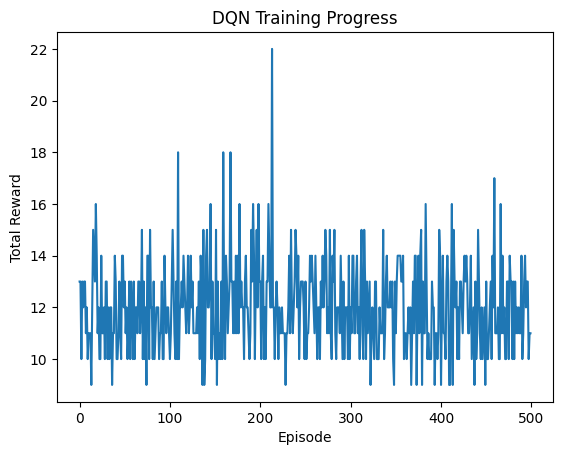

In [ ]:
# 각 에피소드마다 에이전트가 획득한 누적 보상을 저장할 빈 리스트를 생성합니다.
# 이후 학습 진행 상황(즉, 각 에피소드의 성능)을 그래프로 확인하는 데 사용됩니다.
rewards = []  # 보상 저장 리스트

for episode in range(num_episodes): # 총 num_episodes 만큼 에피소드를 반복하면서 학습을 진행합니다.
    state = env.reset()[0]  # 에피소드 시작: 환경 리셋 및 초기화
    total_reward = 0

    for t in range(200): # 한 에피소드에서 최대 200 타임스텝까지 실행합니다.
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        
        memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if done:
            break

    rewards.append(total_reward)

plt.plot(rewards)   # 저장된 각 에피소드의 총 보상을 선 그래프로 그립니다.
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.show()


2. 학습한 DQN을 실제 환경에서 테스트

In [16]:
state = env.reset()[0]
for _ in range(200):
    action = np.argmax(model.predict(state[np.newaxis, :]))
    state, _, done, _, _ = env.step(action)
    env.render()
    if done:
        break
env.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
